In [65]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs, rdmolops, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Draw
from rdkit import RDLogger
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from itertools import product
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


RDLogger.DisableLog('rdApp.*')

In [66]:
# Read in the BROAD dataset, no ligand from PDB here yet
library_no_ligand = pd.read_csv("library_samples.txt", sep = '\t')
library_no_ligand

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,0,98.9,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,0,95.8,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,448055.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20280,BRD-K63068307-001-08-9,ZSTK-474,0,98.66,Selleck,S1072,ZSTK474,417.172,FC(F)c1nc2ccccc2n1-c1nc(nc(n1)N1CCOCC1)N1CCOCC1,HGVNLRPZOWWDKD-UHFFFAOYSA-N,11647372.0,NaN
20281,BRD-K28761384-001-10-9,zuclopenthixol,0,94.95,MedChemEx,HY-A0163,Zuclopenthixol,400.138,OCCN1CCN(CC\C=C2\c3ccccc3Sc3ccc(Cl)cc23)CC1,WFPIAZLQTJBIFN-DVZOWYKESA-N,5311507.0,NaN
20282,BRD-K28761384-300-01-0,zuclopenthixol,0,97.19,Prestwick,Prestw-998,Zuclopenthixol dihydrochloride,400.138,OCCN1CCN(CC\C=C2\c3ccccc3Sc3ccc(Cl)cc23)CC1,WFPIAZLQTJBIFN-DVZOWYKESA-N,5311507.0,NaN
20283,BRD-K28761384-300-01-0,zuclopenthixol,0,96.35,Prestwick,Prestw-998,Zuclopenthixol dihydrochloride,400.138,OCCN1CCN(CC\C=C2\c3ccccc3Sc3ccc(Cl)cc23)CC1,WFPIAZLQTJBIFN-DVZOWYKESA-N,5311507.0,NaN


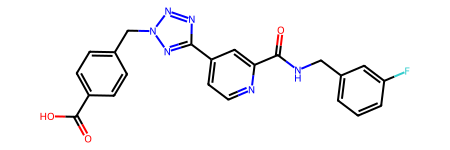

In [67]:
# Initiate smiles for the ligand from PDB (3EJ CACTVS)
mmp13_ligand_smiles = "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"
mmp13_ligand_mol = Chem.MolFromSmiles(mmp13_ligand_smiles)
mmp13_ligand_mol

In [68]:
# Convert smiles in library to RDKit Molecules
library_no_ligand["Mol"] = library_no_ligand["smiles"].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)
library_no_ligand = library_no_ligand.dropna(subset=["Mol"])  # Remove rows where "Mol" is None

library_no_ligand.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id,Mol
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,0,98.9,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE834...
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,0,95.8,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,448055.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...


In [69]:
# Calculate Tanimoto Sim score
mmp13_ligand_fp = AllChem.GetMorganFingerprintAsBitVect(mmp13_ligand_mol, 2, nBits=2048)

def compute_similarity(mol):
    if mol is None:
        return np.nan
    mol_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return DataStructs.TanimotoSimilarity(mmp13_ligand_fp, mol_fp)

library_no_ligand["Tanimoto_Similarity"] = library_no_ligand["Mol"].apply(compute_similarity)

library_no_ligand.head()


C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\3849823623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  library_no_ligand["Tanimoto_Similarity"] = library_no_ligand["Mol"].apply(compute_similarity)


,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id,Mol,Tanimoto_Similarity
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,0,98.9,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE834...,0.105882
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.105882
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.105882
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,0,95.8,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.105882
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,448055.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.067416


Ligand SMILES not found in dataset


C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\4143232229.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


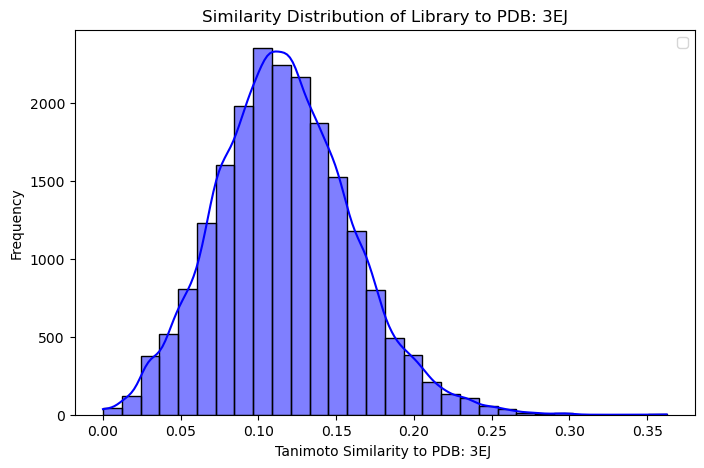

In [70]:
# Plot similarity scores 
plt.figure(figsize=(8, 5))
sns.histplot(library_no_ligand["Tanimoto_Similarity"].dropna(), bins=30, kde=True, color="blue", edgecolor="black")
mmp13_ligand_similarity = library_no_ligand.loc[library_no_ligand["smiles"] == mmp13_ligand_smiles, "Tanimoto_Similarity"]
if not mmp13_ligand_similarity.empty:
    plt.axvline(mmp13_ligand_similarity.iloc[0], color="red", linestyle="dashed", label="MMP-13 Ligand")
else:
    print("Ligand SMILES not found in dataset")
plt.xlabel("Tanimoto Similarity to PDB: 3EJ ")
plt.ylabel("Frequency")
plt.title("Similarity Distribution of Library to PDB: 3EJ")
plt.legend()
plt.show()

In [71]:
# calculating molecular properties
library_no_ligand["Molecular_Weight"] = library_no_ligand["Mol"].apply(lambda x: Descriptors.MolWt(x) if x else np.nan)
library_no_ligand["LogP"] = library_no_ligand["Mol"].apply(lambda x: Descriptors.MolLogP(x) if x else np.nan)
library_no_ligand["HBA"] = library_no_ligand["Mol"].apply(lambda x: rdMolDescriptors.CalcNumHBA(x) if x else np.nan)
library_no_ligand["HBD"] = library_no_ligand["Mol"].apply(lambda x: rdMolDescriptors.CalcNumHBD(x) if x else np.nan)
library_no_ligand["Rotatable_Bonds"] = library_no_ligand["Mol"].apply(lambda x: rdMolDescriptors.CalcNumRotatableBonds(x) if x else np.nan)
library_no_ligand["Aromatic_Rings"] = library_no_ligand["Mol"].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(x) if x else np.nan)
library_no_ligand["TPSA"] = library_no_ligand["Mol"].apply(lambda x: rdMolDescriptors.CalcTPSA(x) if x else np.nan)

library_no_ligand.head()

C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\2177366266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  library_no_ligand["Molecular_Weight"] = library_no_ligand["Mol"].apply(lambda x: Descriptors.MolWt(x) if x else np.nan)
C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\2177366266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  library_no_ligand["LogP"] = library_no_ligand["Mol"].apply(lambda x: Descriptors.MolLogP(x) if x else np.nan)
C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\217736626

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,deprecated_broad_id,Mol,Tanimoto_Similarity,Molecular_Weight,LogP,HBA,HBD,Rotatable_Bonds,Aromatic_Rings,TPSA
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,0,98.9,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE834...,0.105882,267.328,2.8499,3,2,0,2,43.70
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.105882,267.328,2.8499,3,2,0,2,43.70
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.105882,267.328,2.8499,3,2,0,2,43.70
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,0,95.8,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.105882,267.328,2.8499,3,2,0,2,43.70
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDC1...,0.067416,275.348,2.6201,3,1,4,1,47.56


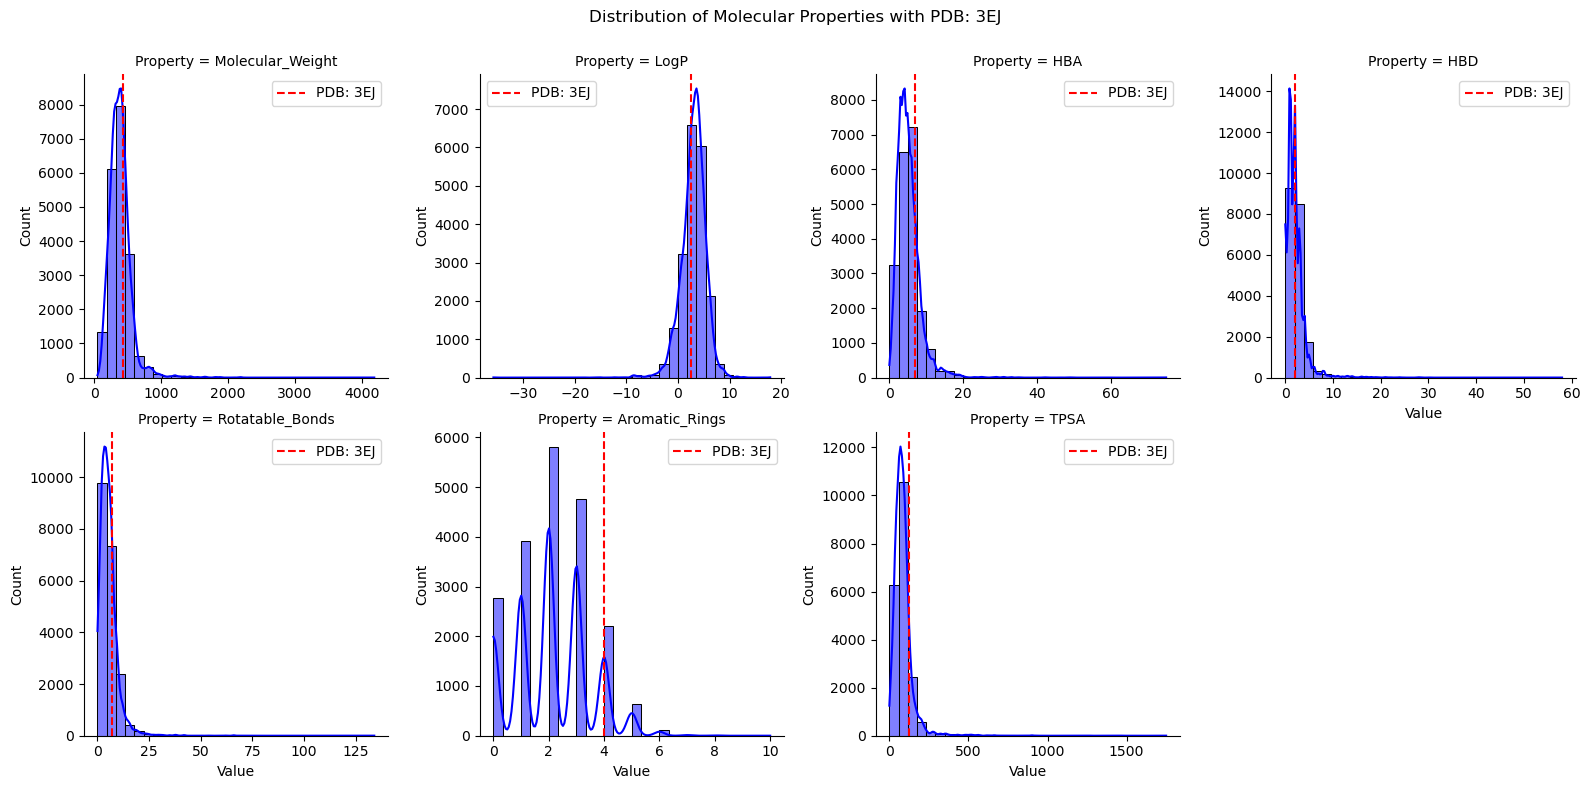

,Tanimoto_Similarity,Molecular_Weight,LogP,HBA,HBD,Rotatable_Bonds,Aromatic_Rings,TPSA
count,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000
mean,0.116672,385.010806,2.990952,5.174398,2.034781,5.378983,2.108196,85.673876
std,0.043555,173.641063,2.373661,3.307767,2.312980,4.663477,1.345338,65.708610
min,0.000000,47.057000,-35.768400,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086614,283.353000,1.771400,3.000000,1.000000,3.000000,1.000000,51.240000
50%,0.114943,369.336000,3.201400,5.000000,2.000000,5.000000,2.000000,76.380000
75%,0.144444,455.551000,4.440000,7.000000,3.000000,7.000000,3.000000,104.040000
max,0.362500,4186.637000,17.853900,75.000000,58.000000,134.000000,10.000000,1749.750000


In [102]:
# Select molecular properties for visualization
properties = ["Molecular_Weight", "LogP", "HBA", "HBD", "Rotatable_Bonds", "Aromatic_Rings", "TPSA"]

# Melt the DataFrame for FacetGrid
library_no_ligand_melted = library_no_ligand.melt(id_vars=["smiles"], value_vars=properties, var_name="Property", value_name="Value")

# Extract Ligand's values
mmp13_ligand_values = {
    "Molecular_Weight": Descriptors.MolWt(mmp13_ligand_mol),
    "LogP": Descriptors.MolLogP(mmp13_ligand_mol),
    "HBA": rdMolDescriptors.CalcNumHBA(mmp13_ligand_mol),
    "HBD": rdMolDescriptors.CalcNumHBD(mmp13_ligand_mol),
    "Rotatable_Bonds": rdMolDescriptors.CalcNumRotatableBonds(mmp13_ligand_mol),
    "Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mmp13_ligand_mol),
    "TPSA":rdMolDescriptors.CalcTPSA(mmp13_ligand_mol)
}

# Create FacetGrid
g = sns.FacetGrid(library_no_ligand_melted, col="Property", col_wrap=4, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.histplot, x="Value", bins=30, kde=True, color="blue", edgecolor="black")

# Add ligand's values as vertical lines
for ax, prop in zip(g.axes.flat, properties):
    ax.axvline(mmp13_ligand_values[prop], color="red", linestyle="dashed", label="PDB: 3EJ")
    ax.legend()

# Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Molecular Properties with PDB: 3EJ")
plt.show()


library_no_ligand.drop(["expected_mass", "pubchem_cid"], axis=1).describe()


In [73]:
# Convert to dataframe and combine into main dataset
columns = library_no_ligand.columns

mmp13_ligand_data = {
    "broad_id" : "MMP13_Ligand",
    "smiles": "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1",
    "Mol": Chem.MolFromSmiles("OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"),  # Create an RDKit Mol object
    "Molecular_Weight": Descriptors.MolWt(mmp13_ligand_mol),
    "LogP": Descriptors.MolLogP(mmp13_ligand_mol),
    "HBA": rdMolDescriptors.CalcNumHBA(mmp13_ligand_mol),
    "HBD": rdMolDescriptors.CalcNumHBD(mmp13_ligand_mol),
    "Rotatable_Bonds": rdMolDescriptors.CalcNumRotatableBonds(mmp13_ligand_mol),
    "Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mmp13_ligand_mol),
    "TPSA": rdMolDescriptors.CalcTPSA(mmp13_ligand_mol)
}

mmp13_ligand_df = pd.DataFrame([mmp13_ligand_data], columns=columns)  # Ensure column order is correct

library_with_ligand = pd.concat([library_no_ligand, mmp13_ligand_df], ignore_index=True).copy()

library_with_ligand.loc[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1", "broad_id"] = "MMP13_Ligand"

library_with_ligand.tail()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,deprecated_broad_id,Mol,Tanimoto_Similarity,Molecular_Weight,LogP,HBA,HBD,Rotatable_Bonds,Aromatic_Rings,TPSA
20237,BRD-K28761384-001-10-9,zuclopenthixol,0,94.95,MedChemEx,HY-A0163,Zuclopenthixol,400.138,OCCN1CCN(CC\C=C2\c3ccccc3Sc3ccc(Cl)cc23)CC1,WFPIAZLQTJBIFN-DVZOWYKESA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81C...,0.112360,400.975,4.23630,4,1,5,2,26.71
20238,BRD-K28761384-300-01-0,zuclopenthixol,0,97.19,Prestwick,Prestw-998,Zuclopenthixol dihydrochloride,400.138,OCCN1CCN(CC\C=C2\c3ccccc3Sc3ccc(Cl)cc23)CC1,WFPIAZLQTJBIFN-DVZOWYKESA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81C...,0.112360,400.975,4.23630,4,1,5,2,26.71
20239,BRD-K28761384-300-01-0,zuclopenthixol,0,96.35,Prestwick,Prestw-998,Zuclopenthixol dihydrochloride,400.138,OCCN1CCN(CC\C=C2\c3ccccc3Sc3ccc(Cl)cc23)CC1,WFPIAZLQTJBIFN-DVZOWYKESA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81C...,0.112360,400.975,4.23630,4,1,5,2,26.71
20240,BRD-K00003448-001-01-9,zuranolone,0,92.59,MedChemEx,HY-103040,Zuranolone,409.273,[H][C@@]12CC[C@H](C(=O)Cn3cc(cn3)C#N)[C@@]1(C)...,HARRKNSQXBRBGZ-GVKWWOCJSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81C...,0.097087,409.574,4.34368,5,1,3,1,78.91
20241,MMP13_Ligand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(...,NaN,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FEDF0...,NaN,432.415,2.55070,7,2,7,4,122.89


In [74]:
# Filter out any compounds over 500 Daltons
library_with_ligand = library_with_ligand[library_with_ligand["Molecular_Weight"] <= 500]

# Remove duplicates by sorted purity and sim score
library_with_ligand = library_with_ligand.sort_values(by=["purity", "Tanimoto_Similarity"], ascending=[False, False])

library_with_ligand = library_with_ligand.drop_duplicates(subset="smiles", keep="first")

# Reset index
library_with_ligand.reset_index(drop=True, inplace=True)

display(library_with_ligand)
len(library_with_ligand)

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,deprecated_broad_id,Mol,Tanimoto_Similarity,Molecular_Weight,LogP,HBA,HBD,Rotatable_Bonds,Aromatic_Rings,TPSA
0,BRD-A51820102-008-28-9,econazole,0,99.93,MicroSource,1501185,ECONAZOLE NITRATE,380.025,Clc1ccc(CO[C@@H](Cn2ccnc2)c2ccc(Cl)cc2Cl)cc1 |...,LEZWWPYKPKIXLL-SFHVURJKSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE834...,0.127907,381.690,5.80140,3,0,6,3,27.05
1,BRD-K76064317-001-08-1,tyrphostin-AG-1296,0,99.91,Selleck,S8024,Tyrphostin AG 1296,266.106,COc1cc2ncc(nc2cc1OC)-c1ccccc1,QNOXYUNHIGOWNY-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81B...,0.133333,266.300,3.31400,4,0,3,3,44.24
2,BRD-K44273375-001-25-0,tolnaftate,0,99.91,MicroSource,1500583,TOLNAFTATE,307.103,CN(C(=S)Oc1ccc2ccccc2c1)c1cccc(C)c1,FUSNMLFNXJSCDI-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81B...,0.083333,307.418,4.94832,2,0,2,3,12.47
3,BRD-K44184170-001-01-7,ospemifene,0,99.9,Selleck,S4285,"2-{4-[(1Z)-4-chloro-1,2-diphenyl-1-butenyl]phe...",378.139,OCCOc1ccc(cc1)C(=C(\CCCl)c1ccccc1)\c1ccccc1,LUMKNAVTFCDUIE-VHXPQNKSSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE819...,0.171053,378.899,5.64570,2,1,8,3,29.46
4,BRD-K67043667-001-26-4,altretamine,0,99.9,MicroSource,1503065,ALTRETAMINE,210.159,CN(C)c1nc(nc(n1)N(C)C)N(C)C,UUVWYPNAQBNQJQ-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE833...,0.031250,210.285,0.06960,6,0,3,1,48.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5673,BRD-K79277568-003-04-7,methoxyamine,1,0,Otava,1270718,NaN,47.037,CON,GMPKIPWJBDOURN-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE846...,0.000000,47.057,-0.49350,2,1,0,0,35.25
5674,BRD-M55321172-001-03-3,potassium-iodide,1,0,Selleck,S1897,Potassium iodide,166.876,[K].I,KIRAUJWBCMCUBY-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE818...,0.000000,167.010,0.23720,0,0,0,0,0.00
5675,BRD-K61230716-236-02-7,sodium-nitrite,1,0,Selleck,S4074,Sodium Nitrite,45.993,[O-][NH2+][O-],ROODZSDSPAHHIS-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81C...,0.000000,48.021,-1.45460,2,1,0,0,62.73
5676,BRD-K19427720-001-01-6,triptan,0,0,Sigma,92340,"2,2,3-trimethylbutane",100.125,CC(C)C(C)(C)C,ZISSAWUMDACLOM-UHFFFAOYSA-N,...,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001FE81B...,0.000000,100.205,2.68850,0,0,0,0,0.00


5678

In [75]:
# Extract molecular descriptors for the MMP-13 ligand
mmp13_logp = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "LogP"].iloc[0]
mmp13_mw = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "Molecular_Weight"].iloc[0]
mmp13_hba = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "HBA"].iloc[0]
mmp13_hbd = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "HBD"].iloc[0]
mmp13_rotbond = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "Rotatable_Bonds"].iloc[0]
mmp13_arorings = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "Aromatic_Rings"].iloc[0]
mmp13_tpsa = library_with_ligand.loc[library_with_ligand["broad_id"] == "MMP13_Ligand", "TPSA"].iloc[0]

In [76]:
# Compute absolute differences from MMP-13 ligand
library_with_ligand["MW_Similarity"] = abs(library_with_ligand["Molecular_Weight"] - mmp13_mw)
library_with_ligand["LogP_Similarity"] = abs(library_with_ligand["LogP"] - mmp13_logp)
library_with_ligand["HBA_Similarity"] = abs(library_with_ligand["HBA"] - mmp13_hba)
library_with_ligand["HBD_Similarity"] = abs(library_with_ligand["HBD"] - mmp13_hbd)
library_with_ligand["Rotatable_Bond_Similarity"] = abs(library_with_ligand["Rotatable_Bonds"] - mmp13_rotbond)
library_with_ligand["Aromatic_Ring_Similarity"] = abs(library_with_ligand["Aromatic_Rings"] - mmp13_arorings)
library_with_ligand["TPSA_Similarity"] = abs(library_with_ligand["TPSA"] - mmp13_tpsa)



In [77]:
# Initialize scaler
scaler = MinMaxScaler()

# Normalize the similarity scores (invert so 1 = most similar)
library_with_ligand[["MW_Similarity", "LogP_Similarity", "HBA_Similarity", "HBD_Similarity", "Rotatable_Bond_Similarity", "Aromatic_Ring_Similarity", "TPSA_Similarity"]] = 1 - scaler.fit_transform(
    library_with_ligand[["MW_Similarity", "LogP_Similarity", "HBA_Similarity", "HBD_Similarity", "Rotatable_Bond_Similarity", "Aromatic_Ring_Similarity", "TPSA_Similarity"]]
)

In [78]:
# Add FP to the dataset
library_with_ligand["Fingerprint"] = library_with_ligand["Mol"].apply(
    lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
)

In [79]:
# Convert RDKit fingerprints to NumPy arrays
def fp_to_numpy(fp):
    arr = np.zeros((1,), dtype=np.float32)
    ConvertToNumpyArray(fp, arr)
    return arr

# Apply conversion
library_with_ligand["FP_Array"] = library_with_ligand["Fingerprint"].apply(fp_to_numpy)

# Stack into a matrix for clustering
X = np.stack(library_with_ligand["FP_Array"].values)
print("Fingerprint matrix shape:", X.shape)  # Should be (num_samples, 2048)

Fingerprint matrix shape: (5678, 2048)


In [80]:
# Extract descriptor similarity scores
desc_cols = ["MW_Similarity", "LogP_Similarity", "HBA_Similarity", "HBD_Similarity", "Rotatable_Bond_Similarity", "Aromatic_Ring_Similarity", "TPSA_Similarity"]  # Add more if needed
X_desc = library_with_ligand[desc_cols].values  # Convert to NumPy array

# Ensure fingerprints and descriptors have compatible shapes
X_combined = np.hstack((X, X_desc))  # Merge fingerprint matrix (X) with descriptors

In [81]:
"""Since fingerprints are binary vectors and descriptors are continuous, we should standardize everything to ensure equal weight in clustering."""
# Standardize combined dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

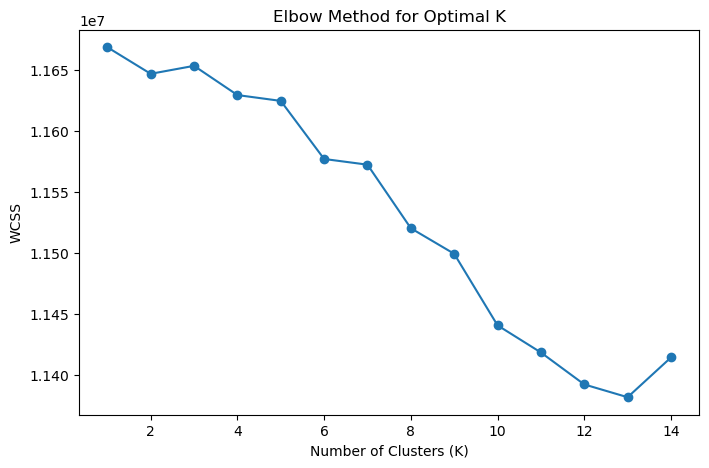

Optimal number of clusters: 1


In [82]:
# Compute WCSS (Within-Cluster Sum of Squares) for multiple K values
wcss = []
K_values = range(1, 15)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

# Find the "elbow" point programmatically
knee = KneeLocator(K_values, wcss, curve="convex", direction="decreasing")
optimal_k = knee.elbow
print(f"Optimal number of clusters: {optimal_k}")

In [83]:
# Run K-Means with the optimal K found from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame

library_with_ligand["PC1_fp"] = X_scaled[:, 0]  # First principal component (Fingerprint PCA)
library_with_ligand["PC2_fp"] = X_scaled[:, 1]  # Second principal component
library_with_ligand["Fingerprint_Cluster"] = cluster_labels  # K-Means cluster assignments

print(library_with_ligand["Fingerprint_Cluster"].value_counts())  # See how many compounds per cluster

Fingerprint_Cluster
0    5678
Name: count, dtype: int64


In [84]:
# First reduce to 50 dimensions
pca_full = PCA(n_components=50)
X_pca_full = pca_full.fit_transform(X_scaled)

# Now reduce to 2D for plotting
pca_2D = PCA(n_components=2)
X_pca = pca_2D.fit_transform(X_pca_full)

<Figure size 800x600 with 0 Axes>

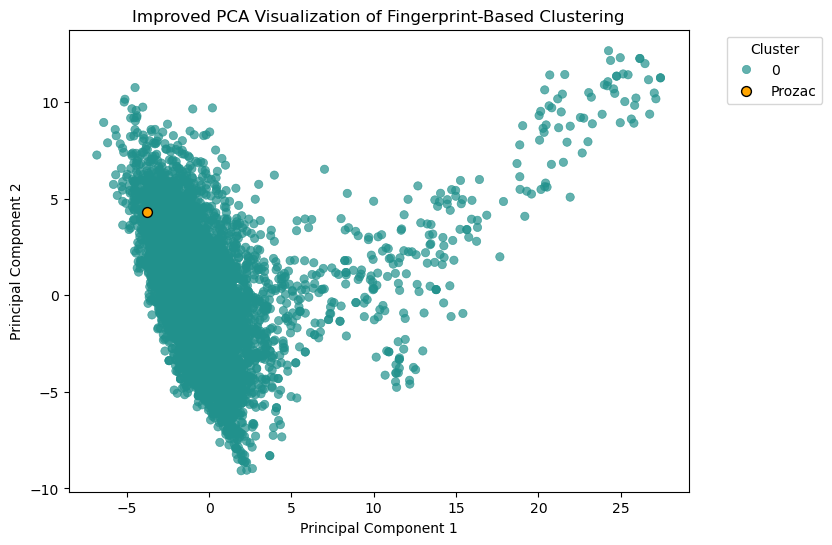

np.int32(0)

In [85]:
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     x="PC1_fp", y="PC2_fp", hue="Fingerprint_Cluster", palette="tab10",
#     data=library_with_ligand, alpha=0.7, edgecolor=None
# )
# plt.xlabel("Principal Component 1 (Fingerprint)")
# plt.ylabel("Principal Component 2 (Fingerprint)")
# plt.title("PCA of Molecular Fingerprints with Clusters")
# plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

# Set figure size
plt.figure(figsize=(8, 6))

# Add PCA data to the dataset
library_with_ligand["PC1_fp"] = X_pca[:, 0]
library_with_ligand["PC2_fp"] = X_pca[:, 1]

# Plot improved PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1_fp", y="PC2_fp", hue="Fingerprint_Cluster", palette="viridis",
    data=library_with_ligand, alpha=0.7, edgecolor=None
)
plt.scatter(library_with_ligand[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["PC1_fp"], 
            library_with_ligand[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["PC2_fp"],
            color="orange", s=50, edgecolors="black", label="Prozac")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Improved PCA Visualization of Fingerprint-Based Clustering")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

mmp13_ligand_cluster = library_with_ligand[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["Fingerprint_Cluster"].values[0]
mmp13_ligand_cluster

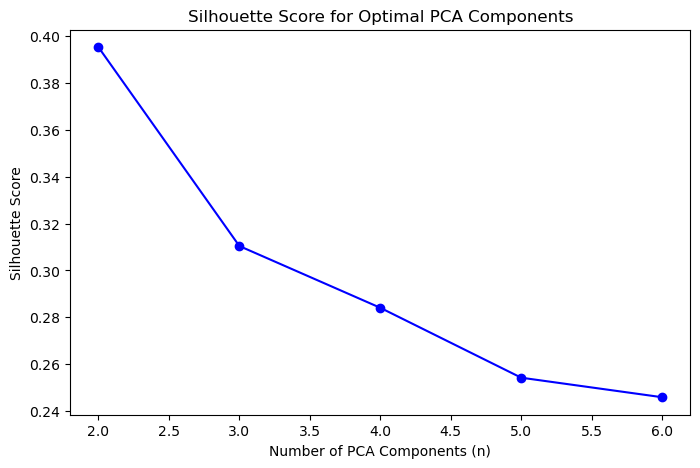

Optimal number of PCA components based on Silhouette Score: 2


In [86]:
# Extract descriptor values
X_desc_only = library_with_ligand[desc_cols].values

# Perform PCA on descriptor data to test different n_components
silhouette_scores = []
component_range = range(2, min(15, X_desc_only.shape[1]))  # Limit to max available features

for n in component_range:
    pca = PCA(n_components=n)
    X_pca_test = pca.fit_transform(X_desc_only)
    
    # Run K-Means with a fixed reasonable K (e.g., 4 from elbow method)
    kmeans = KMeans(n_clusters=4, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca_test)
    
    # Compute silhouette score
    score = silhouette_score(X_pca_test, cluster_labels)
    silhouette_scores.append(score)

# Plot Silhouette Score vs. Number of Components
plt.figure(figsize=(8, 5))
plt.plot(component_range, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of PCA Components (n)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal PCA Components")
plt.show()

# Find the optimal number of PCA components
optimal_n_components = component_range[np.argmax(silhouette_scores)]
print(f"Optimal number of PCA components based on Silhouette Score: {optimal_n_components}")

#############

# # Determine optimal K using the Elbow Method
# wcss = []  # Within-Cluster Sum of Squares
# K_values = range(1, 15)  # Try different K values

# for k in K_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_desc_only)  # Use descriptor-based PCA data
#     wcss.append(kmeans.inertia_)

# # Plot the Elbow Curve to find the best K
# plt.figure(figsize=(8, 5))
# plt.plot(K_values, wcss, marker="o", linestyle="-", color="orange")
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
# plt.title("Elbow Method for Optimal K (Descriptors Only)")
# plt.show()

# # Find the "elbow" point programmatically
# knee = KneeLocator(K_values, wcss, curve="convex", direction="decreasing")
# optimal_k = knee.elbow
# print(f"Optimal number of clusters: {optimal_k}")

In [87]:
# Apply PCA with the optimal number of components
pca_desc = PCA(n_components=optimal_n_components)
X_pca_desc = pca_desc.fit_transform(X_desc_only)

# Store PCA results in the dataset
library_with_ligand["PC1_desc"] = X_pca_desc[:, 0]
library_with_ligand["PC2_desc"] = X_pca_desc[:, 1]

# # Perform PCA on descriptor data to test different n_components
# silhouette_scores = []
# component_range = range(2, min(15, X_desc_only.shape[1]))  # Limit to max available features

# for n in component_range:
#     pca = PCA(n_components=n)
#     X_pca_test = pca.fit_transform(X_desc_only)
    
#     # Run K-Means with a fixed reasonable K (e.g., 4 from elbow method)
#     kmeans = KMeans(n_clusters=4, random_state=42)
#     cluster_labels = kmeans.fit_predict(X_pca_test)
    
#     # Compute silhouette score
#     score = silhouette_score(X_pca_test, cluster_labels)
#     silhouette_scores.append(score)

# # Step 3: Plot Silhouette Score vs. Number of Components
# plt.figure(figsize=(8, 5))
# plt.plot(component_range, silhouette_scores, marker="o", linestyle="-", color="blue")
# plt.xlabel("Number of PCA Components (n)")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Score for Optimal PCA Components")
# plt.show()

# # Find the optimal number of PCA components
# optimal_n_components = component_range[np.argmax(silhouette_scores)]
# print(f"Optimal number of PCA components based on Silhouette Score: {optimal_n_components}")

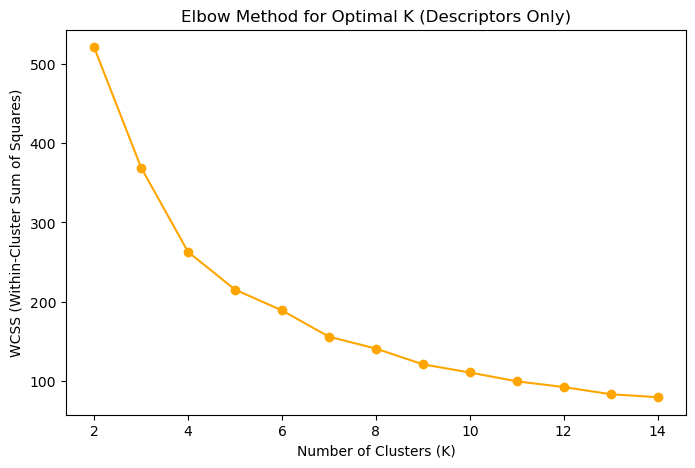

Optimal number of clusters: 5


In [88]:
# Determine optimal K using the Elbow Method
wcss = []  # Within-Cluster Sum of Squares
K_values = range(2, 15)  # Try different K values

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_desc)  # Use PCA-transformed data
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve to find the best K
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker="o", linestyle="-", color="orange")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K (Descriptors Only)")
plt.show()

# Find the optimal K using the elbow method
from kneed import KneeLocator
knee = KneeLocator(K_values, wcss, curve="convex", direction="decreasing")
optimal_k = knee.elbow
print(f"Optimal number of clusters: {optimal_k}")

# # # Perform PCA on descriptor data only
# pca_desc = PCA(n_components=2)
# X_pca_desc = pca_desc.fit_transform(X_desc_only)

# # Store PCA results in the dataset
# library_with_ligand["PC1_desc"] = X_pca_desc[:, 0]
# library_with_ligand["PC2_desc"] = X_pca_desc[:, 1]

# # Run K-Means clustering with the optimal K
# kmeans_desc = KMeans(n_clusters=optimal_k, random_state=42)
# cluster_labels_desc = kmeans_desc.fit_predict(X_desc_only)

# # Assign cluster labels to the dataset
# library_with_ligand["Descriptor_Cluster"] = cluster_labels_desc

# # Check how many compounds belong to each cluster
# print(library_with_ligand["Descriptor_Cluster"].value_counts())


Descriptor_Cluster
3    1338
1    1308
4    1129
2     998
0     905
Name: count, dtype: int64


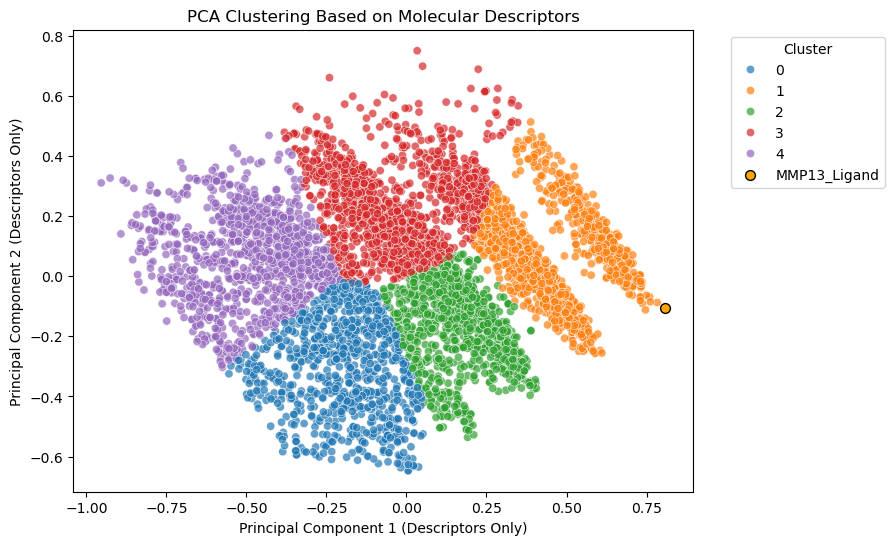

np.int32(1)

In [89]:
# Run K-Means clustering with the optimal K
kmeans_desc = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_desc = kmeans_desc.fit_predict(X_pca_desc)

# Assign cluster labels to the dataset
library_with_ligand["Descriptor_Cluster"] = cluster_labels_desc

# Check how many compounds belong to each cluster
print(library_with_ligand["Descriptor_Cluster"].value_counts())

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1_desc", y="PC2_desc", hue="Descriptor_Cluster", palette="tab10",
    data=library_with_ligand, alpha=0.7, edgecolor="white"
)
plt.scatter(library_with_ligand[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["PC1_desc"], 
            library_with_ligand[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["PC2_desc"],
            color="orange", s=50, edgecolors="black", label="MMP13_Ligand")
plt.xlabel("Principal Component 1 (Descriptors Only)")
plt.ylabel("Principal Component 2 (Descriptors Only)")
plt.title("PCA Clustering Based on Molecular Descriptors")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

mmp13_ligand_cluster1 = library_with_ligand[library_with_ligand["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["Descriptor_Cluster"].values[0]
mmp13_ligand_cluster1

In [90]:
# New dataframe with compounds only belonging to cluster 4 after the first clustering
cluster_1_compounds = library_with_ligand[library_with_ligand["Descriptor_Cluster"] == 1]

cluster_1_compounds.tail()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,Aromatic_Ring_Similarity,TPSA_Similarity,Fingerprint,FP_Array,PC1_fp,PC2_fp,Fingerprint_Cluster,PC1_desc,PC2_desc,Descriptor_Cluster
5371,BRD-K00003219-001-01-9,deferasirox-iron-chelate,0,0.45,MedChemEx,HY-16564,Deferasirox (Fe3+ chelate),427.026,OC(=O)c1ccc(cc1)-n1nc-2nc1-c1ccccc1O[Fe]Oc1ccc...,XLHBYAVMDSNIEM-UHFFFAOYSA-L,...,1.00,0.779953,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.389562,1.308744,0,0.647181,0.091212,1
5386,BRD-K87544030-001-02-8,aminopterin,0,0,MicroSource,1500679,AMINOPTERIN,440.156,Nc1nc(N)c2nc(CNc3ccc(cc3)C(=O)N[C@@H](CCC(O)=O...,TVZGACDUOSZQKY-LBPRGKRZSA-N,...,0.75,0.417316,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.761453,-0.977600,0,0.287019,0.277192,1
5408,BRD-K12413266-001-01-3,casanthranol-variant,0,0,MicroSource,1506179,CASANTHRANOL [cascaroside A shown],434.121,OC[C@H]1O[C@@H](Oc2c3cccc(O)c3c(O)c3c(O)cc(CO)...,XMCJWIFCIIXRGI-BAEVKLAGSA-N,...,0.75,0.653133,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.274185,-1.572203,0,0.333295,0.141600,1
5430,BRD-K17219082-001-02-9,droxicam,0,0,Sigma,MFCD00866032,"5-methyl-3-(2-pyridinyl)-2H,5H-[1,3]oxazino[5,...",357.042,CN1c2c(oc(=O)n(-c3ccccn3)c2=O)-c2ccccc2S1(=O)=O,OEHFRZLKGRKFAS-UHFFFAOYSA-N,...,0.75,0.876684,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.853911,3.334795,0,0.440664,-0.161995,1
5677,MMP13_Ligand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(...,NaN,...,1.00,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.754004,4.319927,0,0.807253,-0.105299,1


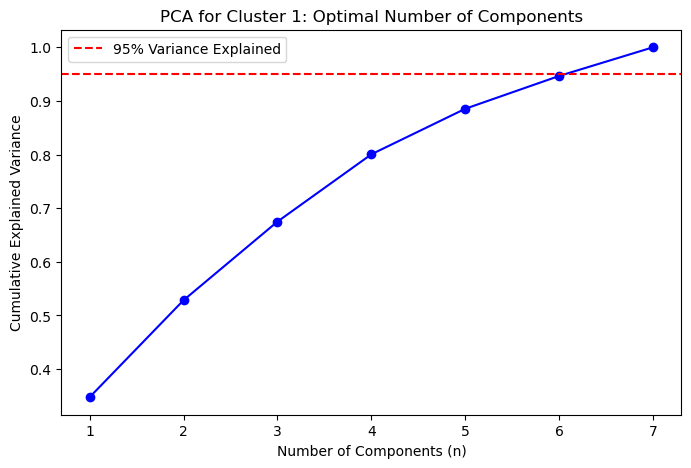

Optimal number of PCA components for Cluster 1: 7


In [91]:
# Extract descriptor data for only Cluster 1 compounds
X_cluster1_desc = cluster_1_compounds[desc_cols].values

# Perform PCA on Cluster 1 data
pca_cluster1 = PCA().fit(X_cluster1_desc)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca_cluster1.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="-", color="blue")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Explained")
plt.xlabel("Number of Components (n)")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA for Cluster 1: Optimal Number of Components")
plt.legend()
plt.show()

# Find optimal n_components for Cluster 1
optimal_n_components_cluster1 = np.argmax(explained_variance >= 0.95) + 1  # +1 because index starts at 0
print(f"Optimal number of PCA components for Cluster 1: {optimal_n_components_cluster1}")

In [92]:
# Apply PCA with the optimal number of components
pca_cluster1 = PCA(n_components=optimal_n_components_cluster1)
X_pca_cluster1 = pca_cluster1.fit_transform(X_cluster1_desc)

# Store PCA results in the dataset
cluster_1_compounds["PC1_desc_cluster1"] = X_pca_cluster1[:, 0]
cluster_1_compounds["PC2_desc_cluster1"] = X_pca_cluster1[:, 1]

C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\718085507.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_compounds["PC1_desc_cluster1"] = X_pca_cluster1[:, 0]
C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\718085507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_compounds["PC2_desc_cluster1"] = X_pca_cluster1[:, 1]


c:\Users\Nick\anaconda3\envs\brandeis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\Nick\anaconda3\envs\brandeis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\Nick\anaconda3\envs\brandeis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\Nick\anaconda3\envs\brandeis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

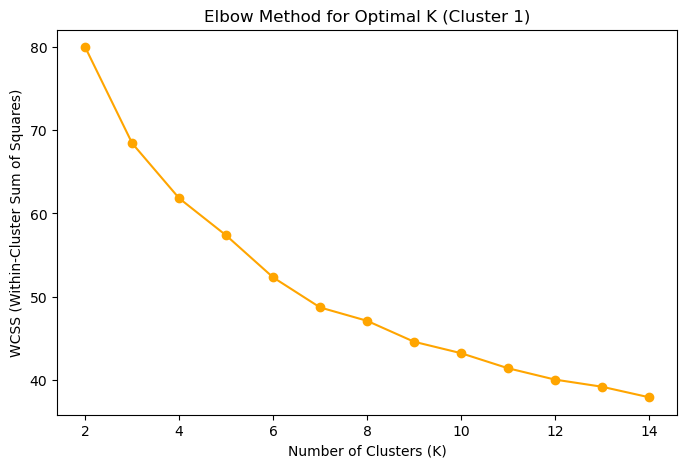

Optimal number of clusters for Cluster 1: 7


In [93]:
# Find optimal K for Cluster 1
wcss = []
K_values = range(2, 15)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_cluster1)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker="o", linestyle="-", color="orange")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K (Cluster 1)")
plt.show()

# Find the optimal number of clusters for Cluster 1
knee = KneeLocator(K_values, wcss, curve="convex", direction="decreasing")
optimal_k_cluster1 = knee.elbow
print(f"Optimal number of clusters for Cluster 1: {optimal_k_cluster1}")

c:\Users\Nick\anaconda3\envs\brandeis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Nick\AppData\Local\Temp\ipykernel_33436\1354570550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_compounds["Sub_Cluster"] = cluster_labels_cluster1


Sub_Cluster
4    236
1    217
6    217
5    203
0    157
2    145
3    133
Name: count, dtype: int64


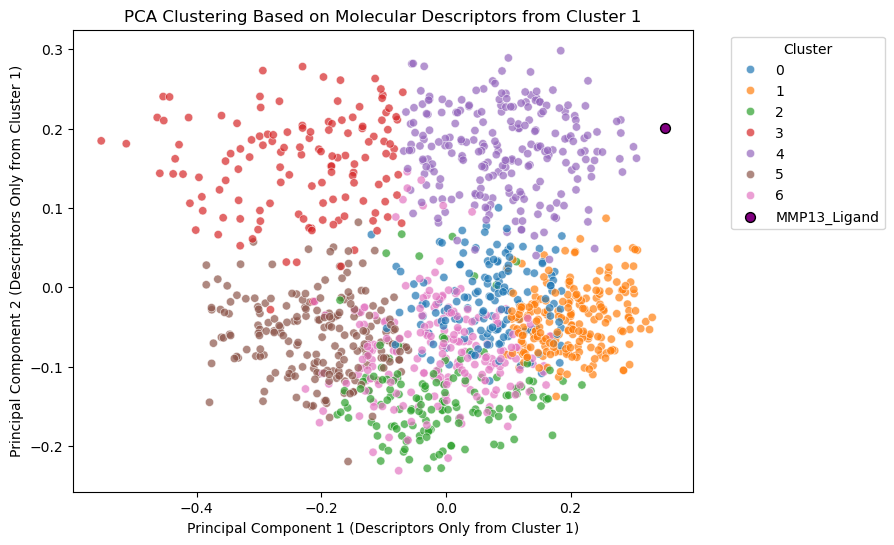

np.int32(4)

In [94]:
# Run K-Means clustering on Cluster 1 data
kmeans_cluster1 = KMeans(n_clusters=optimal_k_cluster1, random_state=42)
cluster_labels_cluster1 = kmeans_cluster1.fit_predict(X_pca_cluster1)

# Assign new cluster labels to dataset
cluster_1_compounds["Sub_Cluster"] = cluster_labels_cluster1

# Check how many compounds belong to each subcluster
print(cluster_1_compounds["Sub_Cluster"].value_counts())

# Plot 
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1_desc_cluster1", y="PC2_desc_cluster1", hue="Sub_Cluster", palette="tab10",
    data=cluster_1_compounds, alpha=0.7, edgecolor="white"
)
plt.scatter(cluster_1_compounds[cluster_1_compounds["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["PC1_desc_cluster1"], 
            cluster_1_compounds[cluster_1_compounds["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["PC2_desc_cluster1"],
            color="purple", s=50, edgecolors="black", label="MMP13_Ligand")
plt.xlabel("Principal Component 1 (Descriptors Only from Cluster 1)")
plt.ylabel("Principal Component 2 (Descriptors Only from Cluster 1)")
plt.title("PCA Clustering Based on Molecular Descriptors from Cluster 1")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

mmp13_ligand_cluster2 = cluster_1_compounds[cluster_1_compounds["smiles"] == "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"]["Sub_Cluster"].values[0]
mmp13_ligand_cluster2

In [95]:
# Filter compounds that belong to Subcluster 2 within Cluster 4
cluster_1_subcluster_4 = cluster_1_compounds[cluster_1_compounds["Sub_Cluster"] == 4]

# Display the first few rows of the new dataframe
cluster_1_subcluster_4.head()

# Optionally, save the new dataframe to a CSV file
# cluster_4_subcluster_2.to_csv("cluster_4_subcluster_2.csv", index=False)

# Print the number of compounds in Subcluster 2
print(f"Number of compounds in Cluster 1 - Subcluster 4: {cluster_1_subcluster_4.shape[0]}")


Number of compounds in Cluster 1 - Subcluster 4: 236


In [96]:
library_with_ligand

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,Aromatic_Ring_Similarity,TPSA_Similarity,Fingerprint,FP_Array,PC1_fp,PC2_fp,Fingerprint_Cluster,PC1_desc,PC2_desc,Descriptor_Cluster
0,BRD-A51820102-008-28-9,econazole,0,99.93,MicroSource,1501185,ECONAZOLE NITRATE,380.025,Clc1ccc(CO[C@@H](Cn2ccnc2)c2ccc(Cl)cc2Cl)cc1 |...,LEZWWPYKPKIXLL-SFHVURJKSA-N,...,0.75,0.420941,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.940835,-0.993915,0,0.191637,0.348479,3
1,BRD-K76064317-001-08-1,tyrphostin-AG-1296,0,99.91,Selleck,S8024,Tyrphostin AG 1296,266.106,COc1cc2ncc(nc2cc1OC)-c1ccccc1,QNOXYUNHIGOWNY-UHFFFAOYSA-N,...,0.75,0.524802,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.673674,1.499580,0,0.108073,0.274264,3
2,BRD-K44273375-001-25-0,tolnaftate,0,99.91,MicroSource,1500583,TOLNAFTATE,307.103,CN(C(=S)Oc1ccc2ccccc2c1)c1cccc(C)c1,FUSNMLFNXJSCDI-UHFFFAOYSA-N,...,0.75,0.332850,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.116833,-1.228309,0,-0.002427,0.504333,3
3,BRD-K44184170-001-01-7,ospemifene,0,99.9,Selleck,S4285,"2-{4-[(1Z)-4-chloro-1,2-diphenyl-1-butenyl]phe...",378.139,OCCOc1ccc(cc1)C(=C(\CCCl)c1ccccc1)\c1ccccc1,LUMKNAVTFCDUIE-VHXPQNKSSA-N,...,0.75,0.435502,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.393879,-1.580270,0,0.145147,0.414299,3
4,BRD-K67043667-001-26-4,altretamine,0,99.9,MicroSource,1503065,ALTRETAMINE,210.159,CN(C)c1nc(nc(n1)N(C)C)N(C)C,UUVWYPNAQBNQJQ-UHFFFAOYSA-N,...,0.25,0.549876,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.466008,-2.767573,0,-0.222268,-0.174299,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5673,BRD-K79277568-003-04-7,methoxyamine,1,0,Otava,1270718,NaN,47.037,CON,GMPKIPWJBDOURN-UHFFFAOYSA-N,...,0.00,0.470485,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.994666,-4.873707,0,-0.855401,0.054917,4
5674,BRD-M55321172-001-03-3,potassium-iodide,1,0,Selleck,S1897,Potassium iodide,166.876,[K].I,KIRAUJWBCMCUBY-UHFFFAOYSA-N,...,0.00,0.257507,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.400393,-5.771221,0,-0.851662,0.292836,4
5675,BRD-K61230716-236-02-7,sodium-nitrite,1,0,Selleck,S4074,Sodium Nitrite,45.993,[O-][NH2+][O-],ROODZSDSPAHHIS-UHFFFAOYSA-N,...,0.00,0.636517,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.177435,-5.757463,0,-0.820170,-0.045851,4
5676,BRD-K19427720-001-01-6,triptan,0,0,Sigma,92340,"2,2,3-trimethylbutane",100.125,CC(C)C(C)(C)C,ZISSAWUMDACLOM-UHFFFAOYSA-N,...,0.00,0.257507,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.148263,-5.781314,0,-0.925883,0.326647,4


In [97]:
# sorted_postcluster = cluster_4_subcluster_2.sort_values(by=["purity", "Tanimoto_Similarity"], ascending=[False, False])

# unique_sorted_postcluster = sorted_postcluster.drop_duplicates(subset="smiles", keep="first")

# # Reset index
# unique_sorted_postcluster.reset_index(drop=True, inplace=True)

# display(unique_sorted_postcluster)
# len(unique_sorted_postcluster)


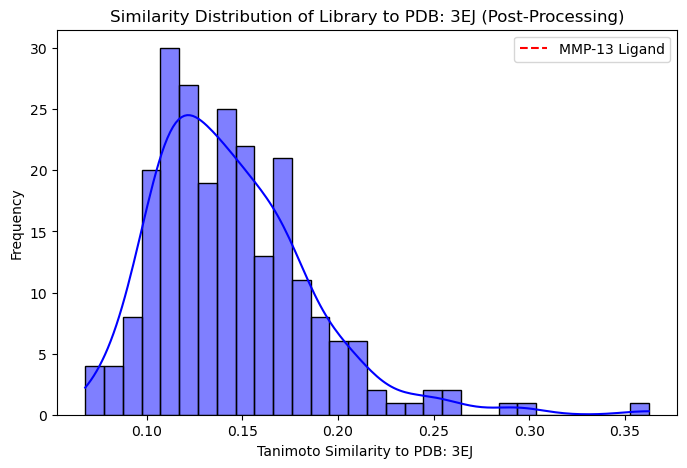

In [98]:
# Plot similarity scores 
plt.figure(figsize=(8, 5))
sns.histplot(cluster_1_subcluster_4["Tanimoto_Similarity"].dropna(), bins=30, kde=True, color="blue", edgecolor="black")
mmp13_ligand_similarity = cluster_1_subcluster_4.loc[cluster_1_subcluster_4["smiles"] == mmp13_ligand_smiles, "Tanimoto_Similarity"]
if not mmp13_ligand_similarity.empty:
    plt.axvline(mmp13_ligand_similarity.iloc[0], color="red", linestyle="dashed", label="MMP-13 Ligand")
else:
    print("Ligand SMILES not found in dataset")
plt.xlabel("Tanimoto Similarity to PDB: 3EJ ")
plt.ylabel("Frequency")
plt.title("Similarity Distribution of Library to PDB: 3EJ (Post-Processing)")
plt.legend()
plt.show()

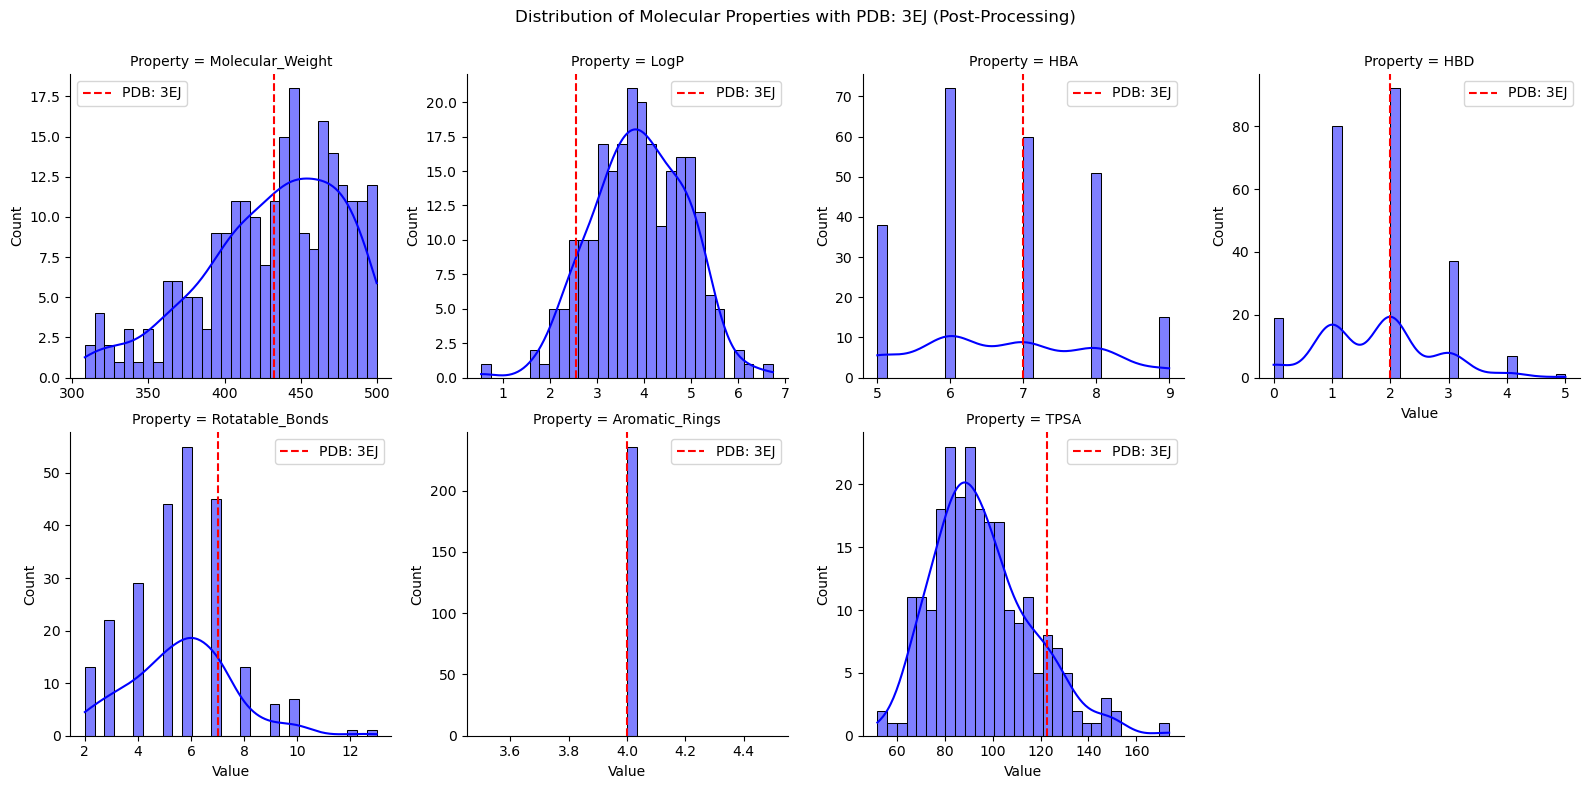

In [99]:
# Select molecular properties for visualization
properties = ["Molecular_Weight", "LogP", "HBA", "HBD", "Rotatable_Bonds", "Aromatic_Rings", "TPSA"]

# Melt the DataFrame for FacetGrid
cluster_1_subcluster_4_melted = cluster_1_subcluster_4.melt(id_vars=["smiles"], value_vars=properties, var_name="Property", value_name="Value")

# Extract Ligand's values
mmp13_ligand_values = {
    "Molecular_Weight": Descriptors.MolWt(mmp13_ligand_mol),
    "LogP": Descriptors.MolLogP(mmp13_ligand_mol),
    "HBA": rdMolDescriptors.CalcNumHBA(mmp13_ligand_mol),
    "HBD": rdMolDescriptors.CalcNumHBD(mmp13_ligand_mol),
    "Rotatable_Bonds": rdMolDescriptors.CalcNumRotatableBonds(mmp13_ligand_mol),
    "Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mmp13_ligand_mol),
    "TPSA":rdMolDescriptors.CalcTPSA(mmp13_ligand_mol)
}

# Create FacetGrid
g = sns.FacetGrid(cluster_1_subcluster_4_melted, col="Property", col_wrap=4, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.histplot, x="Value", bins=30, kde=True, color="blue", edgecolor="black")

# Add ligand's values as vertical lines
for ax, prop in zip(g.axes.flat, properties):
    ax.axvline(mmp13_ligand_values[prop], color="red", linestyle="dashed", label="PDB: 3EJ")
    ax.legend()

# Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Molecular Properties with PDB: 3EJ (Post-Processing)")
plt.show()

In [100]:
cluster_1_subcluster_4

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,FP_Array,PC1_fp,PC2_fp,Fingerprint_Cluster,PC1_desc,PC2_desc,Descriptor_Cluster,PC1_desc_cluster1,PC2_desc_cluster1,Sub_Cluster
44,BRD-K45875383-001-01-2,XBD173,0,99.75,MedChemEx,HY-15527,Emapunil,401.185,CCN(Cc1ccccc1)C(=O)Cn1c2nc(ncc2n(C)c1=O)-c1ccccc1,NBMBIEOUVBHEBM-UHFFFAOYSA-N,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.095563,2.012310,0,0.629000,0.142115,1,0.048124,0.115952,4
51,BRD-K47710001-001-03-7,zopolrestat,0,99.72,Sigma,MFCD00865476,"(4-oxo-3-{[5-(trifluoromethyl)-1,3-benzothiazo...",419.055,OC(=O)Cc1nn(Cc2nc3cc(ccc3s2)C(F)(F)F)c(=O)c2cc...,BCSVCWVQNOXFGL-UHFFFAOYSA-N,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.914286,3.602245,0,0.652381,0.095300,1,0.067334,0.157427,4
58,BRD-K71266197-236-03-9,PSB-06126,0,99.7,Tocris,2574,PSB 06126,444.078,Nc1c2C(=O)c3ccccc3C(=O)c2c(Nc2cccc3ccccc23)cc1...,ZHQRPIRGSWEALJ-UHFFFAOYSA-N,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.863828,0.768167,0,0.691911,-0.021885,1,0.171381,0.172961,4
64,BRD-K19203487-001-01-4,SPP301,0,99.69,MedChemEx,HY-15195,Avosentan,479.126,COc1ccccc1Oc1c(NS(=O)(=O)c2ccc(C)cn2)nc(nc1OC)...,YBWLTKFZAOSWSM-UHFFFAOYSA-N,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-4.605148,3.859768,0,0.623082,0.050131,1,0.105112,0.143552,4
102,BRD-K90747162-001-02-9,KG-5,0,99.59,Tocris,5260,KG 5,459.109,CSc1nc(N)cc(Oc2ccc(cc2)-c2nnc(Nc3cccc(c3)C(F)(...,CMYHZFCJPORPHY-UHFFFAOYSA-N,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.659626,4.079009,0,0.684422,-0.017125,1,0.128398,0.233389,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,BRD-K00004617-001-01-9,imidazoacridinone,0,57.63,Sigma,SML0465,5-{[2-(diethylamino)ethyl]amino}-8-hydroxy-6H-...,350.174,CCN(CC)CCNc1ccc2ncn3c2c1c(=O)c1cc(O)ccc31,CUNDRHORZHFPLY-UHFFFAOYSA-N,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.842979,1.785813,0,0.565209,0.165920,1,0.054548,0.115985,4
5064,BRD-K00003506-001-01-9,risdiplam,0,56.36,MedChemEx,HY-109101,Risdiplam,401.196,Cc1cn2nc(cc(C)c2n1)-c1cc(=O)n2cc(ccc2n1)N1CCNC...,ASKZRYGFUPSJPN-UHFFFAOYSA-N,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.338872,4.842355,0,0.609149,0.126753,1,0.063378,0.100631,4
5145,BRD-K00003427-001-01-9,ilaprazole,0,41.08,MedChemEx,HY-101664,Ilaprazole,366.115,COc1ccnc(C[S@@](=O)c2nc3ccc(cc3[nH]2)-n2cccc2)...,HRRXCXABAPSOCP-AREMUKBSSA-N,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.867298,5.056551,0,0.525519,0.221921,1,-0.052712,0.092983,4
5371,BRD-K00003219-001-01-9,deferasirox-iron-chelate,0,0.45,MedChemEx,HY-16564,Deferasirox (Fe3+ chelate),427.026,OC(=O)c1ccc(cc1)-n1nc-2nc1-c1ccccc1O[Fe]Oc1ccc...,XLHBYAVMDSNIEM-UHFFFAOYSA-L,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.389562,1.308744,0,0.647181,0.091212,1,0.057828,0.152246,4


In [101]:
cluster_1_subcluster_4.to_csv("docking_library.csv", index=False)